### Environments

In [1]:
# pip install psycopg2-binary

In [2]:
from __future__ import print_function
import sys
import psycopg2
import base64
import json
from random import shuffle
import random
import datetime
import os

import boto3
from botocore.exceptions import ClientError
import sagemaker
import s3fs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from ipywidgets import IntSlider, FloatSlider, Checkbox

In [3]:
# set random seeds for reproducibility
np.random.seed(42)
random.seed(42)

In [4]:
sagemaker_session = sagemaker.Session()

In [5]:
s3_bucket = sagemaker_session.default_bucket()
print("s3 bucket: ", s3_bucket)

s3 bucket:  sagemaker-ap-northeast-2-988889742134


In [6]:
s3_prefix = 'sagemaker/redshift-deepar-nyctaxi-demo-notebook'
print("s3 prefix: ", s3_prefix)

s3 prefix:  sagemaker/redshift-deepar-nyctaxi-demo-notebook


In [8]:
region = sagemaker_session.boto_region_name
print("region name: ", region)

region name:  ap-northeast-2


In [9]:
s3_data_path = "s3://{}/{}/data".format(s3_bucket, s3_prefix)
s3_output_path = "s3://{}/{}/output".format(s3_bucket, s3_prefix)
print("s3 input data path: ", s3_data_path)
print("s3 output data path: ", s3_output_path)

s3 input data path:  s3://sagemaker-ap-northeast-2-988889742134/sagemaker/redshift-deepar-nyctaxi-demo-notebook/data
s3 output data path:  s3://sagemaker-ap-northeast-2-988889742134/sagemaker/redshift-deepar-nyctaxi-demo-notebook/output


### Docker ECR Image URI - forcasting-deepar

In [11]:
image_name = sagemaker.amazon.amazon_estimator.get_image_uri(region, "forecasting-deepar", "latest")

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: latest.


### Redshift - Secretsmanager info

In [47]:
def connection_info(secret_name):
    
    session = boto3.session.Session()
    secret_manager_client = session.client(
        service_name='secretsmanager',
        region_name=region
    )
    
    try:
        get_secret_value_response = secret_manager_client.get_secret_value(
            SecretId=secret_name
        )
    except ClientError as e:
        if e.response['Error']['Code'] == 'DecryptionFailureException':
            # Secrets Manager can't decrypt the protected secret text using the provided KMS key.
            raise e
        elif e.response['Error']['Code'] == 'InternalServiceErrorException':
            # An error occurred on the server side.
            raise e
        elif e.response['Error']['Code'] == 'InvalidParameterException':
            # You provided an invalid value for a parameter.
            raise e
        elif e.response['Error']['Code'] == 'InvalidRequestException':
            # You provided a parameter value that is not valid for the current state of the resource.
            raise e
        elif e.response['Error']['Code'] == 'ResourceNotFoundException':
            # We can't find the resource that you asked for.
            raise e
    else:
        # Decrypts secret using the associated KMS key.
        # Depending on whether the secret is a string or binary, one of these fields will be populated.
        if 'SecretString' in get_secret_value_response:
            secret = json.loads(get_secret_value_response['SecretString'])
        else:
            secret = json.loads(base64.b64decode(get_secret_value_response['SecretBinary']))
    
    return secret

In [43]:
con_params = connection_info(secret_name)

print("Connection info: ", con_params)

Connection info:  {'password': ':F3(ibLq9o[.:3CL', 'username': 'master', 'host': 'redshiftcluster-e6qymib7pem4.ctcezicvfjwc.ap-northeast-2.redshift.amazonaws.com', 'port': '8192', 'engine': 'redshift', 'dbClusterIdentifier': 'redshiftcluster-e6qymib7pem4'}


### Redshift cluster connection

In [55]:
def get_connection(db_name, secret_name):
    
    con_params = connection_info(secret_name)
#     print("Connection parameters: ", con_params)
    print("Connection info retrieved from Secrets manager")
    
    rsf_conn = psycopg2.connect(
                dbname=db_name,
                host=con_params['host'],
                port=con_params['port'],
                user=con_params['username'],
                password=con_params['password']
            )
    
    return rsf_conn

In [56]:
db_name = 'nyctaxi'
secret_name = 'arn:aws:secretsmanager:ap-northeast-2:988889742134:secret:nyctaxisecret-7MXnAI'

conn = get_connection(db_name, secret_name)

Connection info retrieved from Secrets manager


### Redshift Query Execution

In [57]:
def get_redshift_query_execution(db_name, secret_name, sql):
    
    conn = get_connection(db_name=db_name, secret_name=secret_name)
    cur = None
    
    try:
        cur = conn.cursor()
        res = cur.execute(sql)
    except Exception as e:
        conn.rollback()
        raise e
    finally:
        if cur:
            cur.close()
        if conn:
            conn.close()
    
    return res

In [58]:
secret_name = 'arn:aws:secretsmanager:ap-northeast-2:988889742134:secret:nyctaxisecret-7MXnAI'
timeout_statement = "set statement_timeout = 1200000"
db_name = 'nyctaxi'

result = get_redshift_query_execution(db_name=db_name, secret_name=secret_name, sql=timeout_statement)
print("Result: ", result)

Connection info retrieved from Secrets manager
Result:  None


### Run sql start

In [63]:
redshift_unload_path = s3_output_path + '/unload/'
redshift_iam_role = "arn:aws:iam::988889742134:role/Redshift-Analytics-Lab-RedshiftRole-1FKF6QKB14C58"

In [64]:
results = []
query_str = "unload('select coalesce(v1.pickup_timestamp_norm, v2.pickup_timestamp_norm) as pickup_timestamp_norm \
, coalesce(v1.vendor_1, 0) as vendor_1 \
, coalesce(v2.vendor_2, 0) as vendor_2 \
from \
(select case when extract(minute from lpep_dropoff_datetime) between 0 and 14 then dateadd(minute, 0, date_trunc(''hour'', lpep_dropoff_datetime)) \
when extract(minute from lpep_dropoff_datetime) between 15 and 29 then dateadd(minute, 15, date_trunc(''hour'', lpep_dropoff_datetime)) \
when extract(minute from lpep_dropoff_datetime) between 30 and 44 then dateadd(minute, 30, date_trunc(''hour'', lpep_dropoff_datetime)) \
when extract(minute from lpep_dropoff_datetime) between 45 and 59 then dateadd(minute, 45, date_trunc(''hour'', lpep_dropoff_datetime)) end as pickup_timestamp_norm \
, count(1) as vendor_1 \
from taxischema.nyc_greentaxi \
where vendorid = 1 group by 1) v1 \
full outer join \
(select case when extract(minute from lpep_dropoff_datetime) between 0 and 14 then dateadd(minute, 0, date_trunc(''hour'', lpep_dropoff_datetime)) \
when extract(minute from lpep_dropoff_datetime) between 15 and 29 then dateadd(minute, 15, date_trunc(''hour'', lpep_dropoff_datetime)) \
when extract(minute from lpep_dropoff_datetime) between 30 and 44 then dateadd(minute, 30, date_trunc(''hour'', lpep_dropoff_datetime)) \
when extract(minute from lpep_dropoff_datetime) between 45 and 59 then dateadd(minute, 45, date_trunc(''hour'', lpep_dropoff_datetime)) end as pickup_timestamp_norm \
, count(1)  as vendor_2 \
from taxischema.nyc_greentaxi \
where vendorid = 2 group by 1) v2 on v1.pickup_timestamp_norm = v2.pickup_timestamp_norm order by pickup_timestamp_norm ;') to '" \
+ redshift_unload_path + "' iam_role '" + redshift_iam_role + "' format as CSV header ALLOWOVERWRITE GZIP"

In [65]:
print("Query string: \n", query_str)

Query string: 
 unload('select coalesce(v1.pickup_timestamp_norm, v2.pickup_timestamp_norm) as pickup_timestamp_norm , coalesce(v1.vendor_1, 0) as vendor_1 , coalesce(v2.vendor_2, 0) as vendor_2 from (select case when extract(minute from lpep_dropoff_datetime) between 0 and 14 then dateadd(minute, 0, date_trunc(''hour'', lpep_dropoff_datetime)) when extract(minute from lpep_dropoff_datetime) between 15 and 29 then dateadd(minute, 15, date_trunc(''hour'', lpep_dropoff_datetime)) when extract(minute from lpep_dropoff_datetime) between 30 and 44 then dateadd(minute, 30, date_trunc(''hour'', lpep_dropoff_datetime)) when extract(minute from lpep_dropoff_datetime) between 45 and 59 then dateadd(minute, 45, date_trunc(''hour'', lpep_dropoff_datetime)) end as pickup_timestamp_norm , count(1) as vendor_1 from taxischema.nyc_greentaxi where vendorid = 1 group by 1) v1 full outer join (select case when extract(minute from lpep_dropoff_datetime) between 0 and 14 then dateadd(minute, 0, date_trunc(

In [66]:
query_result = get_redshift_query_execution(db_name=db_name, secret_name=secret_name, sql=query_str)

Connection info retrieved from Secrets manager


In [67]:
print("Query Result: ", query_result)

Query Result:  None


### Load dataframe from s3 .gzip files

In [131]:
s3_client = boto3.client('s3')

def load_df_from_s3(s3_path):
    
    assert s3_path.startswith('s3://')
    
    s3_path_split_list = s3_path.split('/')
    print("s3 path split list: ", s3_path_split_list)
    
    bucket_nm = s3_path_split_list[2]
    print("s3 path bucket name: ", bucket_nm)
    
    bucket_prefix = '/'.join(s3_path_split_list[3:])
    print("s3 path prefix name: ", bucket_prefix)
    
    datafiles = s3_client.list_objects_v2(
        Bucket=bucket_nm,
        Prefix=bucket_prefix
    )['Contents']
    
    prefix_df = []
    
    s3_fs = s3fs.S3FileSystem()
    
    for file in datafiles[0:]:
        file_path = file['Key']
        
        with s3_fs.open('s3://' + bucket_nm + '/' + file_path) as f:
            df = pd.read_csv(
                f,
                compression='gzip',
                index_col=0,
                parse_dates=True,
                decimal=',',
                sep=','
            )
            
            prefix_df.append(df)
            print(f"File retrieved {file_path}")
            
    return pd.concat(prefix_df)

In [132]:
pd_df = load_df_from_s3(redshift_unload_path)

s3 path split list:  ['s3:', '', 'sagemaker-ap-northeast-2-988889742134', 'sagemaker', 'redshift-deepar-nyctaxi-demo-notebook', 'output', 'unload', '']
s3 path bucket name:  sagemaker-ap-northeast-2-988889742134
s3 path prefix name:  sagemaker/redshift-deepar-nyctaxi-demo-notebook/output/unload/
File retrieved sagemaker/redshift-deepar-nyctaxi-demo-notebook/output/unload/0000_part_00.gz
File retrieved sagemaker/redshift-deepar-nyctaxi-demo-notebook/output/unload/0001_part_00.gz
File retrieved sagemaker/redshift-deepar-nyctaxi-demo-notebook/output/unload/0002_part_00.gz
File retrieved sagemaker/redshift-deepar-nyctaxi-demo-notebook/output/unload/0003_part_00.gz


### Visualization dataframe

In [133]:
pd_df.shape

(17506, 2)

In [134]:
pd_df.head(5)

,vendor_1,vendor_2
pickup_timestamp_norm,,
2009-01-01 00:00:00,0,1
2009-01-01 00:30:00,0,6
2009-01-01 00:45:00,0,6
2009-01-01 01:00:00,0,4
2009-01-01 02:15:00,0,2


In [135]:
num_timeseries = pd_df.shape[1]
print('Num timeseries: ', num_timeseries)

Num timeseries:  2


In [136]:
data_trip = pd_df.resample('2H').sum() / 8

In [137]:
timeseries = []

for i in range(num_timeseries):
    timeseries.append(
        np.trim_zeros(
            data_trip.iloc[:,i],
            trim='f'
        )
    )

In [140]:
timeseries[0]

pickup_timestamp_norm
2018-09-13 12:00:00    0.125
2018-09-13 14:00:00    0.000
2018-09-13 16:00:00    0.000
2018-09-13 18:00:00    0.000
2018-09-13 20:00:00    0.000
                       ...  
2019-07-01 14:00:00    0.000
2019-07-01 16:00:00    0.000
2019-07-01 18:00:00    0.000
2019-07-01 20:00:00    0.000
2019-07-01 22:00:00    0.000
Freq: 2H, Name: vendor_1, Length: 3498, dtype: float64

In [141]:
timeseries[1]

pickup_timestamp_norm
2008-12-31 22:00:00    0.750
2009-01-01 00:00:00    4.125
2009-01-01 02:00:00    0.625
2009-01-01 04:00:00    0.125
2009-01-01 06:00:00    0.000
                       ...  
2019-07-01 14:00:00    1.000
2019-07-01 16:00:00    1.125
2019-07-01 18:00:00    1.000
2019-07-01 20:00:00    1.000
2019-07-01 22:00:00    0.500
Freq: 2H, Name: vendor_2, Length: 46009, dtype: float64

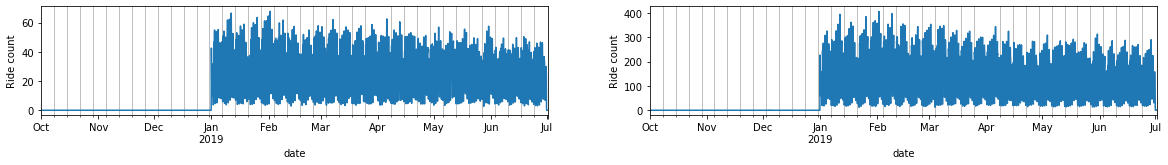

In [142]:
fig, axs = plt.subplots(1, 2, figsize=(20, 2), sharex=True)
axx = axs.ravel()
for i in range(0, 2):
    timeseries[i].loc["2018-10-01":"2019-12-31"].plot(ax=axx[i])
    axx[i].set_xlabel("date")
    axx[i].set_ylabel("Ride count")
    axx[i].grid(which='minor', axis='x')

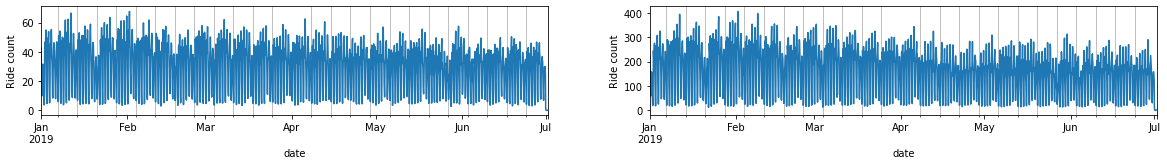

In [144]:
fig, axs = plt.subplots(1, 2, figsize=(20, 2), sharex=True)
axx = axs.ravel()
for i in range(0, 2):
    timeseries[i].loc["2019-01-01":"2019-08-01"].plot(ax=axx[i])
    axx[i].set_xlabel("date")
    axx[i].set_ylabel("Ride count")
    axx[i].grid(which='minor', axis='x')

### Train and Test splits

Often times one is interested in evaluating the model or tuning its hyperparameters by looking at error metrics on a hold-out test set. Here we split the available data into train and test sets for evaluating the trained model. For standard machine learning tasks such as classification and regression, one typically obtains this split by randomly separating examples into train and test sets. However, in forecasting it is important to do this train/test split based on time rather than by time series.

In this example, we will reserve the last section of each of the time series for evalutation purpose and use only the first part as training data. 

In [145]:
# we use 2 hour frequency for the time series
freq = '2H'

# we predict for 7 days
prediction_length = 7 * 12

# we also use 7 days as context length, this is the number of state updates accomplished before making predictions
context_length = 7 * 12

In [148]:
# we specify here the portion of the data that is used for training
# the model sees data from '2019-01-01' to '2019-04-01' for training

start_dataset = pd.Timestamp("2019-01-01 00:00:00", freq=freq)

end_training = pd.Timestamp("2019-04-01 00:00:00", freq=freq)

The DeepAR JSON input format represents each time series as a JSON object. In the simplest case each time series just consists of a start time stamp (``start``) and a list of values (``target``). For more complex cases, DeepAR also supports the fields ``dynamic_feat`` for time-series features and ``cat`` for categorical features, which we will use  later.

In [150]:
print("start: ", str(start_dataset))

start:  2019-01-01 00:00:00


In [152]:
for ts in timeseries:
    target_list = ts[start_dataset:end_training][:-1].tolist()
    print(len(target_list))

1080
1080


In [154]:
training_data = [
    {
        "start": str(start_dataset),
        "target": ts[start_dataset:end_training][:-1].tolist()
    }
    for ts in timeseries
]

In [200]:
len(training_data[0]['target'])

1080

As test data, we will consider time series extending beyond the training range: these will be used for computing test scores, by using the trained model to forecast their trailing 7 days, and comparing predictions with actual values.
To evaluate our model performance on more than one week, we generate test data that extends to 1, 2, 3, 4 weeks beyond the training range. This way we perform *rolling evaluation* of our model.

In [163]:
num_test_windows = 4

idx = []
print(len(pd.date_range(start_dataset, end_training)))

period_range = len(pd.date_range(start_dataset, end_training))

for i in range(1, num_test_windows + 1):
    idx.append(
        pd.date_range(
            start_dataset,
            periods=period_range + (i * prediction_length),
            freq=freq
        )
    )

test_data = [
    {
        "start": str(start_dataset),
        "target": ts[idx[k]].tolist()
    }
    for k in range(0, num_test_windows)
    for ts in timeseries
]

91


In [201]:
len(test_data[0]["target"])

175

In [202]:
def write_dicts_to_file(path, data):
    with open(path, 'wb') as fp:
        for d in data:
            fp.write(json.dumps(d).encode("utf-8"))
            fp.write("\n".encode('utf-8'))

In [203]:
%%time
write_dicts_to_file("train.json", training_data)
write_dicts_to_file("test.json", test_data)

CPU times: user 0 ns, sys: 3.33 ms, total: 3.33 ms
Wall time: 7.05 ms


Now that we have the data files locally, let us copy them to S3 where DeepAR can access them. Depending on your connection, this may take a couple of minutes

### Copy train/test split data to s3

In [206]:
s3_resource = boto3.resource('s3')

def copy_to_s3(local_file, s3_path, override=True):
    
    assert s3_path.startswith('s3://')
    
    s3_path_split_list = s3_path.split('/')
    print("s3 path split list: ", s3_path_split_list)
    
    bucket_nm = s3_path_split_list[2]
    print("bucket name: ", bucket_nm)
    
    bucket_prefix = '/'.join(s3_path_split_list[3:])
    print("bucket prefix: ", bucket_prefix)
    
    bucket_objects = s3_resource.Bucket(
        bucket_nm
    ).objects.filter(
        Prefix=bucket_prefix
    )
    
    if len(list(bucket_objects)) > 0:
        if not override:
            print(f"File s3://{bucket_nm}/{bucket_prefix} already exists.")
            print("Set override to upload anyway\n")
            return
        else:
            print("Overwriting existing file")
    
    with open(local_file, 'rb') as data:
        print('Uploading file to {}'.format(s3_path))
        s3_resource.Bucket(
            bucket_nm
        ).put_object(
            Key=bucket_prefix,
            Body=data
        )

In [207]:
copy_to_s3("train.json", s3_data_path + "/train/train.json")

s3 path split list:  ['s3:', '', 'sagemaker-ap-northeast-2-988889742134', 'sagemaker', 'redshift-deepar-nyctaxi-demo-notebook', 'data', 'train', 'train.json']
bucket name:  sagemaker-ap-northeast-2-988889742134
bucket prefix:  sagemaker/redshift-deepar-nyctaxi-demo-notebook/data/train/train.json
Overwriting existing file
Uploading file to s3://sagemaker-ap-northeast-2-988889742134/sagemaker/redshift-deepar-nyctaxi-demo-notebook/data/train/train.json


In [209]:
s3_file_system = s3fs.S3FileSystem()

with s3_file_system.open(s3_data_path + "/train/train.json", 'rb') as fp:
    print(fp.readline().decode("utf-8")[:100] + "...")

{"start": "2019-01-01 00:00:00", "target": [42.625, 42.125, 21.875, 14.25, 9.875, 13.375, 18.0, 26.5...


In [210]:
copy_to_s3("test.json", s3_data_path + "/test/test.json")

s3 path split list:  ['s3:', '', 'sagemaker-ap-northeast-2-988889742134', 'sagemaker', 'redshift-deepar-nyctaxi-demo-notebook', 'data', 'test', 'test.json']
bucket name:  sagemaker-ap-northeast-2-988889742134
bucket prefix:  sagemaker/redshift-deepar-nyctaxi-demo-notebook/data/test/test.json
Uploading file to s3://sagemaker-ap-northeast-2-988889742134/sagemaker/redshift-deepar-nyctaxi-demo-notebook/data/test/test.json


In [211]:
s3_file_system = s3fs.S3FileSystem()

with s3_file_system.open(s3_data_path + "/train/train.json", 'rb') as fp:
    print(fp.readline().decode("utf-8")[:100] + "...")

{"start": "2019-01-01 00:00:00", "target": [42.625, 42.125, 21.875, 14.25, 9.875, 13.375, 18.0, 26.5...


### Train a model

In [214]:
# Here, we define the estimator that will launch the training job

role = sagemaker.get_execution_role()

estimator = sagemaker.estimator.Estimator(
    sagemaker_session=sagemaker_session,
    image_uri=image_name,
    role=role,
    train_instance_count=1,
    train_instance_type='ml.c4.2xlarge',
    base_job_name='redshift-deepar-nyctaxi-demo',
    output_path=s3_output_path
)

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [215]:
hyperparameters = {
    "time_freq": freq,
    "epochs": "400",
    "early_stopping_patience": "40",
    "mini_batch_size": "64",
    "learning_rate": "5E-4",
    "context_length": str(context_length),
    "prediction_length": str(prediction_length)
}

In [216]:
estimator.set_hyperparameters(**hyperparameters)

In [217]:
%%time

data_channels = {
    "train": "{}/train/".format(s3_data_path),
    "test": "{}/test/".format(s3_data_path)
}

estimator.fit(
    inputs=data_channels,
    wait=True
)

2022-04-07 06:54:05 Starting - Starting the training job...
2022-04-07 06:54:33 Starting - Preparing the instances for trainingProfilerReport-1649314445: InProgress
......
2022-04-07 06:55:34 Downloading - Downloading input data...
2022-04-07 06:56:06 Training - Downloading the training image...
2022-04-07 06:56:30 Training - Training image download completed. Training in progress..Arguments: train
[04/07/2022 06:56:35 INFO 139984794219904 integration.py:592] worker started
[04/07/2022 06:56:35 INFO 139984794219904] Reading default configuration from /opt/amazon/lib/python3.6/site-packages/algorithm/resources/default-input.json: {'_kvstore': 'auto', '_num_gpus': 'auto', '_num_kv_servers': 'auto', '_tuning_objective_metric': '', 'cardinality': 'auto', 'dropout_rate': '0.10', 'early_stopping_patience': '', 'embedding_dimension': '10', 'learning_rate': '0.001', 'likelihood': 'student-t', 'mini_batch_size': '128', 'num_cells': '40', 'num_dynamic_feat': 'auto', 'num_eval_samples': '100', 'n

### Create endpoint and predictor

Now that we have a trained model, we can use it to perform predictions by deploying it to an endpoint.

**Note: Remember to delete the endpoint after running this experiment. A cell at the very bottom of this notebook will do that: make sure you run it at the end.**

To query the endpoint and perform predictions, we can define the following utility class: this allows making requests using `pandas.Series` objects rather than raw JSON strings.

Create endpoint and predictor
Now that we have a trained model, we can use it to perform predictions by deploying it to an endpoint.

Note: Remember to delete the endpoint after running this experiment. A cell at the very bottom of this notebook will do that: make sure you run it at the end.

To query the endpoint and perform predictions, we can define the following utility class: this allows making requests using pandas.Series objects rather than raw JSON strings.

In [229]:
class DeepARPredictor(sagemaker.predictor.Predictor):
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    def predict(self, ts, cat=None, dynamic_feat=None, 
                num_samples=100, return_samples=False, quantiles=["0.1", "0.5", "0.9"]):
        """Requests the prediction of for the time series listed in `ts`, each with the (optional)
        corresponding category listed in `cat`.
        
        ts -- `pandas.Series` object, the time series to predict
        cat -- integer, the group associated to the time series (default: None)
        num_samples -- integer, number of samples to compute at prediction time (default: 100)
        return_samples -- boolean indicating whether to include samples in the response (default: False)
        quantiles -- list of strings specifying the quantiles to compute (default: ["0.1", "0.5", "0.9"])
        
        Return value: list of `pandas.DataFrame` objects, each containing the predictions
        """
        prediction_time = ts.index[-1] + pd.Timedelta(freq)
        quantiles = [str(q) for q in quantiles]
        req = self.__encode_request(ts, cat, dynamic_feat, num_samples, return_samples, quantiles)
        res = super(DeepARPredictor, self).predict(req)
        return self.__decode_response(res, ts.index.freq, prediction_time, return_samples)
    
    def __encode_request(self, ts, cat, dynamic_feat, num_samples, return_samples, quantiles):
        instance = series_to_dict(ts, cat if cat is not None else None, dynamic_feat if dynamic_feat else None)

        configuration = {
            "num_samples": num_samples,
            "output_types": ["quantiles", "samples"] if return_samples else ["quantiles"],
            "quantiles": quantiles
        }
        
        http_request_data = {
            "instances": [instance],
            "configuration": configuration
        }
        
        return json.dumps(http_request_data).encode('utf-8')
    
    def __decode_response(self, response, freq, prediction_time, return_samples):
        # we only sent one time series so we only receive one in return
        # however, if possible one will pass multiple time series as predictions will then be faster
        predictions = json.loads(response.decode('utf-8'))['predictions'][0]
        prediction_length = len(next(iter(predictions['quantiles'].values())))
        #prediction_index = pd.DatetimeIndex(start=prediction_time, freq=freq, periods=prediction_length)
        prediction_index = pd.date_range(prediction_time, periods = prediction_length, freq=freq)
        if return_samples:
            dict_of_samples = {'sample_' + str(i): s for i, s in enumerate(predictions['samples'])}
        else:
            dict_of_samples = {}
        return pd.DataFrame(data={**predictions['quantiles'], **dict_of_samples}, index=prediction_index)

    def set_frequency(self, freq):
        self.freq = freq
        
def encode_target(ts):
    return [x if np.isfinite(x) else "NaN" for x in ts]        

def series_to_dict(ts, cat=None, dynamic_feat=None):
    """Given a pandas.Series object, returns a dictionary encoding the time series.

    ts -- a pands.Series object with the target time series
    cat -- an integer indicating the time series category

    Return value: a dictionary
    """
    obj = {"start": str(ts.index[0]), "target": encode_target(ts)}
    if cat is not None:
        obj["cat"] = cat
    if dynamic_feat is not None:
        obj["dynamic_feat"] = dynamic_feat        
    return obj

Now we can deploy the model and create and endpoint that can be queried using our custom DeepARPredictor class.

In [230]:
predictor = estimator.deploy(
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
    predictor_cls=DeepARPredictor)

--------!

In [231]:
predictor.predict(ts=timeseries[1], quantiles=[0.10, 0.5, 0.90]).head()

ModelError: An error occurred (ModelError) when calling the InvokeEndpoint operation: Received client error (415) from primary with message "Customer Error: Content-Type header value 'application/octet-stream' not supported (caused by KeyError)

Caused by: 'application/octet-stream'". See https://ap-northeast-2.console.aws.amazon.com/cloudwatch/home?region=ap-northeast-2#logEventViewer:group=/aws/sagemaker/Endpoints/redshift-deepar-nyctaxi-demo-2022-04-07-08-20-28-192 in account 988889742134 for more information.

### Delete endpoints

In [232]:
predictor.delete_endpoint()